In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [7]:
train = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\train.csv")
test = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\test.csv")
alldata = pd.concat([train,test])
alldata

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,NaN


In [8]:
alldata["u-g"] = alldata["u"]-alldata["g"]
alldata["g-r"] = alldata["g"]-alldata["r"]
alldata["r-i"] = alldata["r"]-alldata["i"]
alldata["i-z"] = alldata["i"]-alldata["z"]

alldata["d1"] = alldata["dered_u"]-alldata["dered_g"]
alldata["d2"] = alldata["dered_g"]-alldata["dered_r"]
alldata["d3"] = alldata["dered_r"]-alldata["dered_i"]
alldata["d4"] = alldata["dered_i"]-alldata["dered_z"]

# alldata["d5"] = alldata["u"]-alldata["r"] # 6591   # 6666
# alldata["d6"] = alldata["u"]-alldata["i"] # 6648   
# alldata["d7"] = alldata["u"]-alldata["z"]  # 6548   
# alldata["d8"] = alldata["g"]-alldata["i"] # 6639   
# alldata["d9"] = alldata["g"]-alldata["z"] # 6608   # 6675
# alldata["d10"] = alldata["r"]-alldata["z"] # 6614   
# alldata['d11'] = alldata['dered_u'] - alldata['dered_z'] # 6595

alldata['d_dered_ig'] = alldata['dered_i'] - alldata['dered_g'] # 6605
alldata['d_dered_zg'] = alldata['dered_z'] - alldata['dered_g'] # 6641
alldata['d_dered_rz'] = alldata['dered_r'] - alldata['dered_z'] # 6641

alldata['d_dered_u'] = alldata['dered_u'] - alldata['u'] # 6638
alldata['d_dered_g'] = alldata['dered_g'] - alldata['g'] # 6666
alldata['d_dered_r'] = alldata['dered_r'] - alldata['r'] # 6638
alldata['d_dered_i'] = alldata['dered_i'] - alldata['i'] # 6598
alldata['d_dered_z'] = alldata['dered_z'] - alldata['z'] # 6642

alldata

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,u-g,g-r,r-i,i-z,d1,d2,d3,d4,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,2.9272,1.3273,1.3371,0.7328,2.8665,1.3027,1.3230,0.7232,-2.6257,-3.3488,2.0462,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,0.9902,0.6096,0.1840,0.0995,0.9619,0.5931,0.1751,0.1016,-0.7683,-0.8698,0.2767,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,0.9610,0.2891,0.1428,0.0435,0.9211,0.2466,0.1183,0.0257,-0.3649,-0.3905,0.1440,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0,4.4719,0.9676,0.3262,0.2603,4.3590,0.9074,0.2926,0.2395,-1.2000,-1.4395,0.5321,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0,3.7543,1.6568,0.7182,0.3415,3.3376,1.5709,0.6727,0.3144,-2.2436,-2.5579,0.9871,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN,1.0117,0.3909,0.1483,0.0598,0.9428,0.3073,0.0999,0.0191,-0.4072,-0.4263,0.1190,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN,0.7946,0.1196,-0.3962,0.1591,0.7594,0.0949,-0.4056,0.1680,0.3108,0.1428,-0.2376,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN,1.1580,0.0806,-0.0373,-0.0041,1.0383,-0.0294,-0.0996,-0.0357,0.1289,0.1647,-0.1353,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,NaN,1.2989,0.4680,0.3105,0.2278,1.2835,0.4323,0.2897,0.2075,-0.7220,-0.9295,0.4972,-0.1282,-0.1129,-0.0772,-0.0564,-0.0361


In [9]:
alldata2 = alldata.drop(["id","class","airmass_u","airmass_g","airmass_r","airmass_i","airmass_z"], axis=1)
alldata2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,u-g,g-r,r-i,i-z,d1,d2,d3,d4,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,2.9272,1.3273,1.3371,0.7328,2.8665,1.3027,1.3230,0.7232,-2.6257,-3.3488,2.0462,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,0.9902,0.6096,0.1840,0.0995,0.9619,0.5931,0.1751,0.1016,-0.7683,-0.8698,0.2767,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,0.9610,0.2891,0.1428,0.0435,0.9211,0.2466,0.1183,0.0257,-0.3649,-0.3905,0.1440,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,4.4719,0.9676,0.3262,0.2603,4.3590,0.9074,0.2926,0.2395,-1.2000,-1.4395,0.5321,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,3.7543,1.6568,0.7182,0.3415,3.3376,1.5709,0.6727,0.3144,-2.2436,-2.5579,0.9871,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.0117,0.3909,0.1483,0.0598,0.9428,0.3073,0.0999,0.0191,-0.4072,-0.4263,0.1190,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957
79996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,0.7946,0.1196,-0.3962,0.1591,0.7594,0.0949,-0.4056,0.1680,0.3108,0.1428,-0.2376,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631
79997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1580,0.0806,-0.0373,-0.0041,1.0383,-0.0294,-0.0996,-0.0357,0.1289,0.1647,-0.1353,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618
79998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.2989,0.4680,0.3105,0.2278,1.2835,0.4323,0.2897,0.2075,-0.7220,-0.9295,0.4972,-0.1282,-0.1129,-0.0772,-0.0564,-0.0361


In [10]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(train2, train["class"], test_size = 0.2, random_state = 42 )

In [26]:
# clf = RandomForestClassifier(n_estimators=400,
#                              min_samples_leaf=10,
#                              max_features=0.7,
#                              random_state=42,
#                              n_jobs=-1,
#                              verbose = 1)
# clf.fit(x_train, y_train)
# p_val = clf.predict(x_valid)
# p_tst = clf.predict(test2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [63]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=1000,
                         num_leaves=200,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.8,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=42,
                         n_jobs=-1)

clf.fit(x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='multiclass',
        early_stopping_rounds=30)
p_val = clf.predict(x_valid)
p_tst = clf.predict(test2)

[1]	valid_0's multi_logloss: 0.874696
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.784656
[3]	valid_0's multi_logloss: 0.709984
[4]	valid_0's multi_logloss: 0.649113
[5]	valid_0's multi_logloss: 0.597126
[6]	valid_0's multi_logloss: 0.549569
[7]	valid_0's multi_logloss: 0.507961
[8]	valid_0's multi_logloss: 0.472238
[9]	valid_0's multi_logloss: 0.440879
[10]	valid_0's multi_logloss: 0.413183
[11]	valid_0's multi_logloss: 0.388002
[12]	valid_0's multi_logloss: 0.365579
[13]	valid_0's multi_logloss: 0.347066
[14]	valid_0's multi_logloss: 0.329845
[15]	valid_0's multi_logloss: 0.314803
[16]	valid_0's multi_logloss: 0.300264
[17]	valid_0's multi_logloss: 0.288174
[18]	valid_0's multi_logloss: 0.276568
[19]	valid_0's multi_logloss: 0.265887
[20]	valid_0's multi_logloss: 0.256497
[21]	valid_0's multi_logloss: 0.247917
[22]	valid_0's multi_logloss: 0.240954
[23]	valid_0's multi_logloss: 0.234321
[24]	valid_0's multi_logloss: 0.227732
[25]	valid_0

In [64]:
print(f'{accuracy_score(y_valid, p_val) * 100:.4f}%')

93.4172%


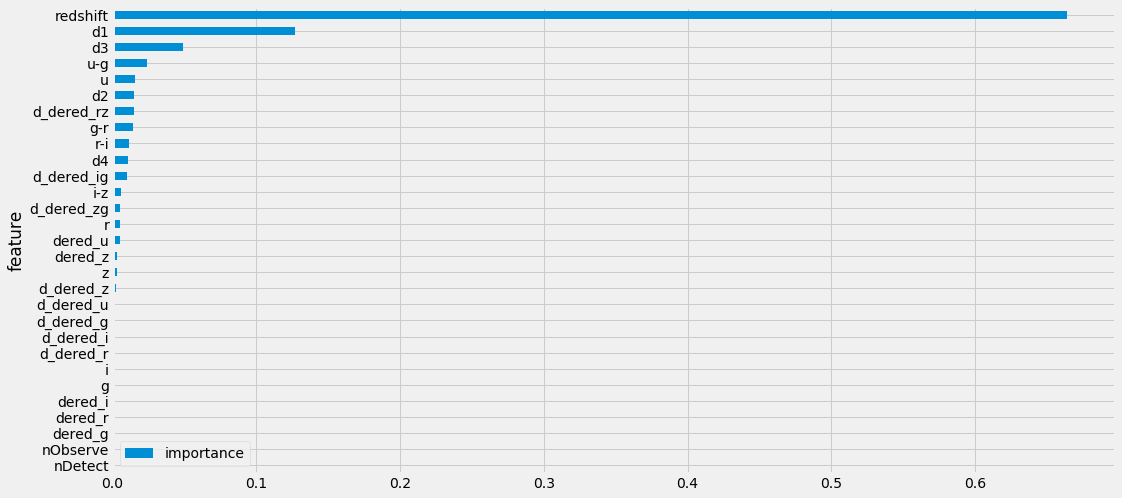

In [29]:
imp = pd.DataFrame({'feature': train2.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [31]:
sub = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\sample_submission.csv")
sub["class"] = p_tst
sub

,id,class
0,320000,2
1,320001,0
2,320002,2
3,320003,0
4,320004,2
...,...,...
79995,399995,0
79996,399996,1
79997,399997,0
79998,399998,2


In [32]:
sub.to_csv("rf과제.csv", index=False)